In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from stripes.detection import Detector
%matplotlib inline

Чтение файлов с диска:

In [2]:
def read_images(path):
    images_names = glob.glob(path + '/' + '*.jpg')
    return [cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB) for image_name in images_names]

images = read_images("../images/tables/stripes/")
print len(images)

10


Размер итогового изображения с таблицей / с тестовой полоской:

In [3]:
scale_coeff = 5

In [4]:
w_target, h_target = 148 * scale_coeff, 166 * scale_coeff
print "{} x {}" .format(w_target, h_target)

740 x 830


In [5]:
w_strip, h_strip = 120 * scale_coeff, 5 * scale_coeff
print "{} x {}" .format(w_strip, h_strip)

600 x 25


Координаты ячеек на шаблоне

In [6]:
coords_mm = {}

coords_mm['strip'] = ((128.5, 10.5), (138.5, 160.5))

coords_mm['LEU_1'] = ((38, 17), (47.5, 23))
coords_mm['LEU_2'] = ((77.5, 17), (87, 23))
coords_mm['LEU_3'] = ((90.5, 17), (100, 23))
coords_mm['LEU_4'] = ((103.5, 17), (113, 23))
coords_mm['LEU_5'] = ((117, 17), (126.5, 23))

coords_mm['NIT_1'] = ((38, 31), (47.5, 37))
coords_mm['NIT_2'] = ((90.5, 31), (100, 37))
coords_mm['NIT_3'] = ((117, 31), (126.5, 37))

coords_mm['URO_1'] = ((38, 45), (47.5, 51))
coords_mm['URO_2'] = ((50.5, 45), (60, 51))
coords_mm['URO_3'] = ((90.5, 45), (100, 51))
coords_mm['URO_4'] = ((103.5, 45), (113, 51))
coords_mm['URO_5'] = ((117, 45), (126.5, 51))

coords_mm['PRO_1'] = ((38, 61), (47.5, 67))
coords_mm['PRO_2'] = ((50.5, 61), (60, 67))
coords_mm['PRO_3'] = ((77.5, 61), (87, 67))
coords_mm['PRO_4'] = ((90.5, 61), (100, 67))
coords_mm['PRO_5'] = ((103.5, 61), (113, 67))
coords_mm['PRO_6'] = ((117, 61), (126.5, 67))

coords_mm['PH_1'] = ((38, 74), (47.5, 80))
coords_mm['PH_2'] = ((50.5, 74), (60, 80))
coords_mm['PH_3'] = ((64, 74), (73.5, 80))
coords_mm['PH_4'] = ((77.5, 74), (87, 80))
coords_mm['PH_5'] = ((90.5, 74), (100, 80))
coords_mm['PH_6'] = ((103.5, 74), (113, 80))
coords_mm['PH_7'] = ((117, 74), (126.5, 80))

coords_mm['BLO_1'] = ((38, 92), (47.5, 98))
coords_mm['BLO_2'] = ((50.5, 92), (60, 98))
coords_mm['BLO_3'] = ((64, 92), (73.5, 98))
coords_mm['BLO_4'] = ((77.5, 92), (87, 98))
coords_mm['BLO_5'] = ((90.5, 92), (100, 98))
coords_mm['BLO_6'] = ((103.5, 92), (113, 98))
coords_mm['BLO_7'] = ((117, 92), (126.5, 98))

coords_mm['SG_1'] = ((38, 104.5), (47.5, 110.5))
coords_mm['SG_2'] = ((50.5, 104.5), (60, 110.5))
coords_mm['SG_3'] = ((64, 104.5), (73.5, 110.5))
coords_mm['SG_4'] = ((77.5, 104.5), (87, 110.5))
coords_mm['SG_5'] = ((90.5, 104.5), (100, 110.5))
coords_mm['SG_6'] = ((103.5, 104.5), (113, 110.5))
coords_mm['SG_7'] = ((117, 104.5), (126.5, 110.5))

coords_mm['KET_1'] = ((38, 120), (47.5, 126))
coords_mm['KET_2'] = ((64, 120), (73.5, 126))
coords_mm['KET_3'] = ((77.5, 120), (87, 126))
coords_mm['KET_4'] = ((90.5, 120), (100, 126))
coords_mm['KET_5'] = ((103.5, 120), (113, 126))
coords_mm['KET_6'] = ((117, 120), (126.5, 126))

coords_mm['BIL_1'] = ((38, 135), (47.5, 141))
coords_mm['BIL_2'] = ((90.5, 135), (100, 141))
coords_mm['BIL_3'] = ((103.5, 135), (113, 141))
coords_mm['BIL_4'] = ((117, 135), (126.5, 141))

coords_mm['GLU_1'] = ((38, 153.5), (47.5, 159.5))
coords_mm['GLU_2'] = ((64, 153.5), (73.5, 159.5))
coords_mm['GLU_3'] = ((77.5, 153.5), (87, 159.5))
coords_mm['GLU_4'] = ((90.5, 153.5), (100, 159.5))
coords_mm['GLU_5'] = ((103.5, 153.5), (113, 159.5))
coords_mm['GLU_6'] = ((117, 153.5), (126.5, 159.5))

coords_scaled = {}
for key in coords_mm:
    coords_scaled[key] = ((int(coords_mm[key][0][0] * scale_coeff), int(coords_mm[key][0][1] * scale_coeff)),
                          (int(coords_mm[key][1][0] * scale_coeff), int(coords_mm[key][1][1] * scale_coeff)))

Предобработка (размеры ядер и параметры фильтров пока хардкод под картинки 1280х960)

In [81]:
def contrast(image):
    if len(image.shape) == 2:
        return cv2.equalizeHist(image)
    else:
        return cv2.cvtColor(cv2.equalizeHist(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)), cv2.COLOR_GRAY2RGB)

def denoise(image, ksize=15):
    return cv2.medianBlur(image, ksize=ksize)


def binarize(image, blocksize=11, C=0):
    if len(image.shape) == 2:
        out = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY, blockSize=blocksize, C=C)
    else:
        out = cv2.adaptiveThreshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY, blockSize=blocksize, C=C)
    return out


def morphology_open(image, ksize=3):
    kernel = np.ones(ksize)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)


def morphology_close(image, ksize=3):
    kernel = np.ones(ksize)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

def find_contours(image):
    blank = np.zeros(shape=(image.shape[0], image.shape[1]))
    
    if len(image.shape) == 3:
        binary = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        binary = cv2.threshold(binary, np.mean(binary, axis=(0, 1)), 255, cv2.THRESH_BINARY)[1]
    elif len(image.shape) == 2:
        binary = cv2.threshold(image, np.mean(image, axis=(0, 1)), 255, cv2.THRESH_BINARY)[1]
    _, contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)        
    print len(contours)
    
    for j in xrange(len(contours)):
        cv2.drawContours(binary, contours, j, (127, 127, 127), 2)
    return binary

Работа с контурами:

In [126]:
def get_max_area_contour_id(contours):
    max_area = 0.
    max_contour_id = -1
    for j, contour in enumerate(contours):
        new_area = cv2.contourArea(contour)
        if new_area >= max_area:
            max_area = new_area
            max_contour_id = j
    return max_contour_id


def approximate_contour(contour, eps=5*1e-3, closed=True):
    return cv2.approxPolyDP(contour, epsilon=eps*cv2.arcLength(contour, closed=closed), closed=closed)


def get_correct_arrangement(rect):
    """
    Find arrangment indices as follows
    # 0 -> 1
    # |    |
    # 3 <- 2
    """
    arrangement = [-1] * 4
    x1i, x2i, x3i, x4i = np.argsort(rect[:, 0])
    
    if rect[x1i, 1] > rect[x2i, 1]:
        arrangement[0] = x2i
        arrangement[3] = x1i
    else:
        arrangement[0] = x1i
        arrangement[3] = x2i

    if rect[x3i, 1] > rect[x4i, 1]:
        arrangement[1] = x4i
        arrangement[2] = x3i
    else:
        arrangement[2] = x4i
        arrangement[1] = x3i

    return arrangement

def check_contour(contour, eps_area, eps_cos=None):
    
    if cv2.contourArea(contour) < eps_area:
        return False
    
    approx = approximate_contour(contour)
#     if len(approx) != 4:
#         return False
    
    if not cv2.isContourConvex(approx):
        return False
    
    #TODO: близость к прямоугольнику (все углы c |cos| < eps_cos)
    return True

Преобразование изображения:

In [9]:
def get_warp_matrix(src_rect, dist_rect):
    assert src_rect.shape == dist_rect.shape, "Shapes mismatch: {} != {}".format(src_rect.shape, dist_rect.shape)
    h, status = cv2.findHomography(src_rect, dist_rect)
    return h


def warp(image, warp_matrix, dist_shape=(w_target, h_target)):
    return cv2.warpPerspective(image, warp_matrix, dist_shape)

Часть 1 - детектирование всего шаблона:

In [30]:
def run_on_table(image):
    
    # Предобработка
    image_denoised = denoise(image)
    image_binary = binarize(image_denoised)
    image_morph = morphology_open(image_binary)
    
    # Контуры
    r, contours, h = cv2.findContours(image_morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxId = get_max_area_contour_id(contours)
    contour = contours[maxId]
    
    poly = approximate_contour(contour)
    
    image_contoured = image.copy()
    cv2.drawContours(image_contoured, [poly], 0, (255, 0, 0), 5)
    
    if len(poly) != 4:
        print "Failed to approx with 4 points"
        plt.figure(figsize=(7, 16))
        plt.title("Contoured image")
        plt.imshow(image_contoured)
        plt.show()        
        return None
    
    # Трансформация
    correct_arrangement = get_correct_arrangement(np.squeeze(poly, 1))
    src_rect = np.squeeze(poly, 1)[correct_arrangement]
    
    dist_rect = np.array([[[0, 0]],
                          [[w_target, 0]],
                          [[w_target, h_target]],
                          [[0, h_target]]])

    warp_matrix = get_warp_matrix(np.expand_dims(src_rect, 1), dist_rect)
    image_warped = warp(image, warp_matrix)
    
    # Отрисовка ячеек
    image_warped_copy = image_warped.copy()
    for key, rect in coords_scaled.items():
        cv2.rectangle(image_warped_copy, rect[0], rect[1], (255, 255, 0), 2)
    
    
    plt.figure(figsize=(15, 35))
    plt.subplot(1, 2, 1)
    plt.title("Contoured image")
    plt.imshow(image_contoured)
    plt.subplot(1, 2, 2)
    plt.title("Cropped image")
    plt.imshow(image_warped_copy)
    plt.show()
    
    return image_warped

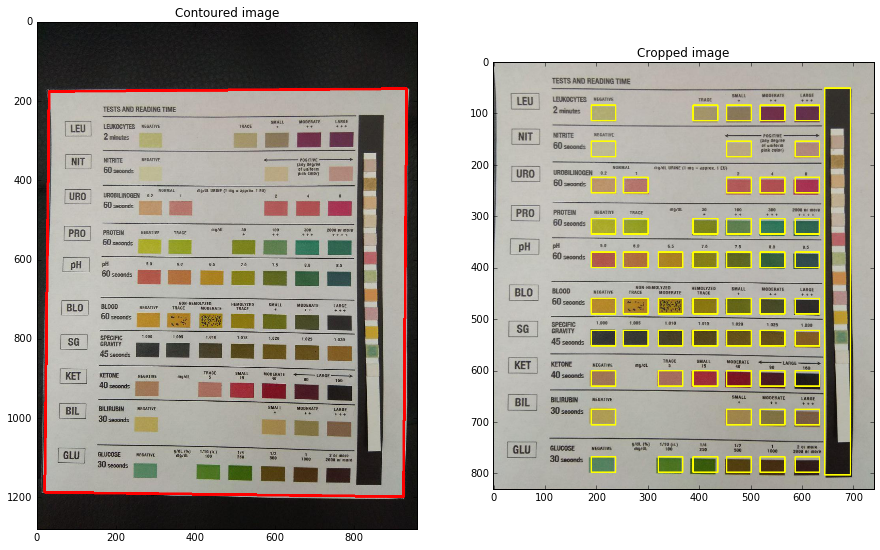

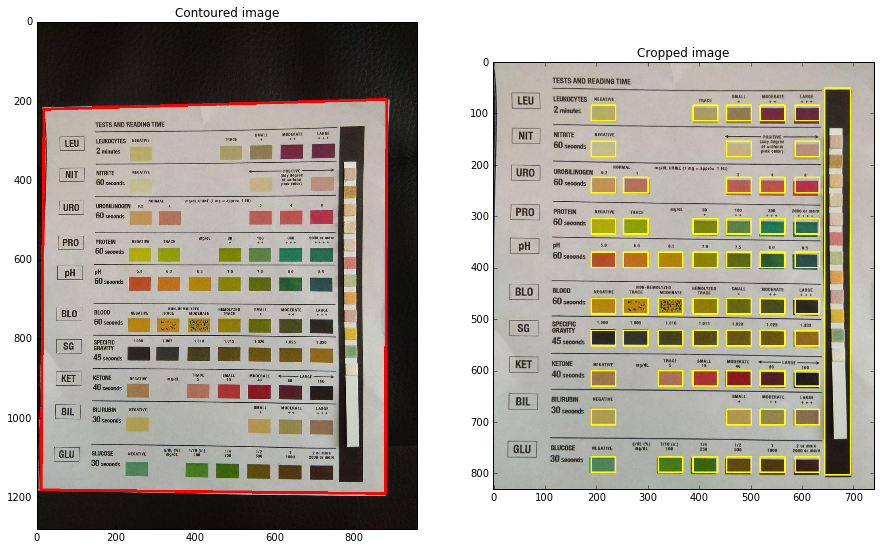

Failed to approx with 4 points


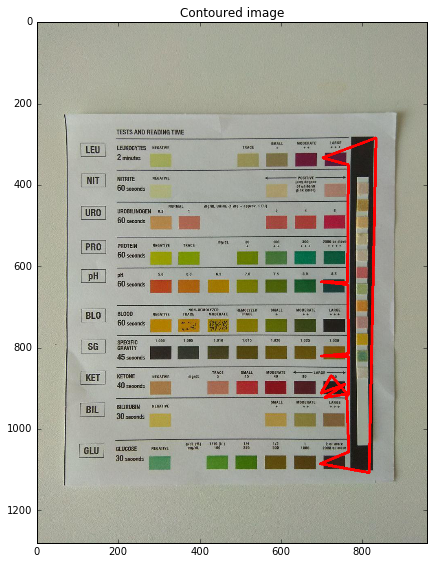

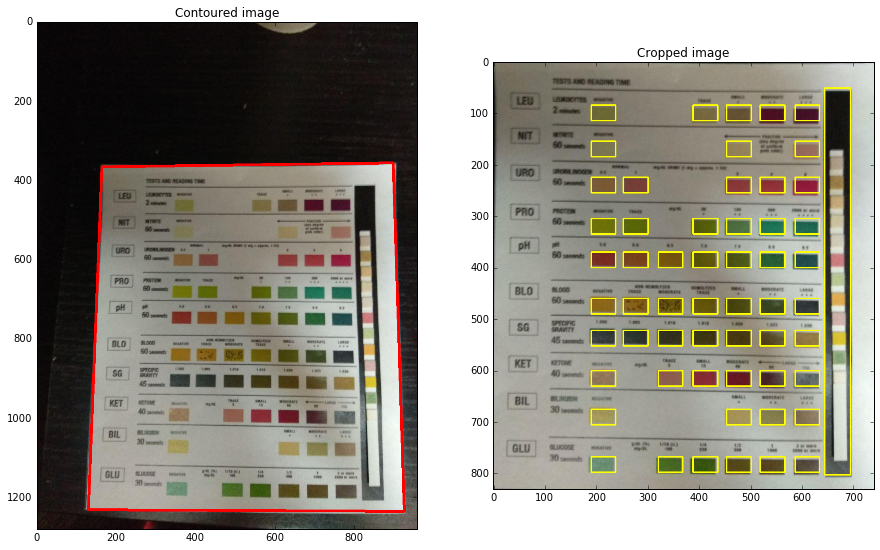

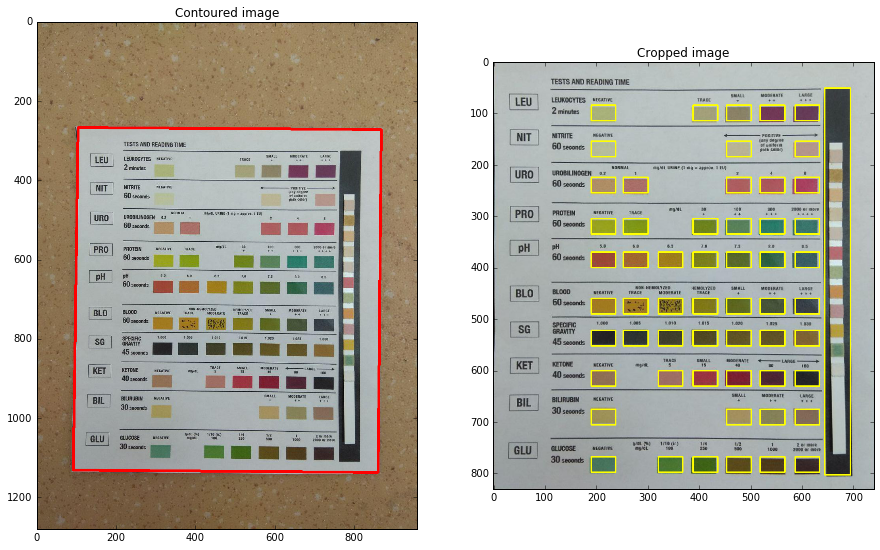

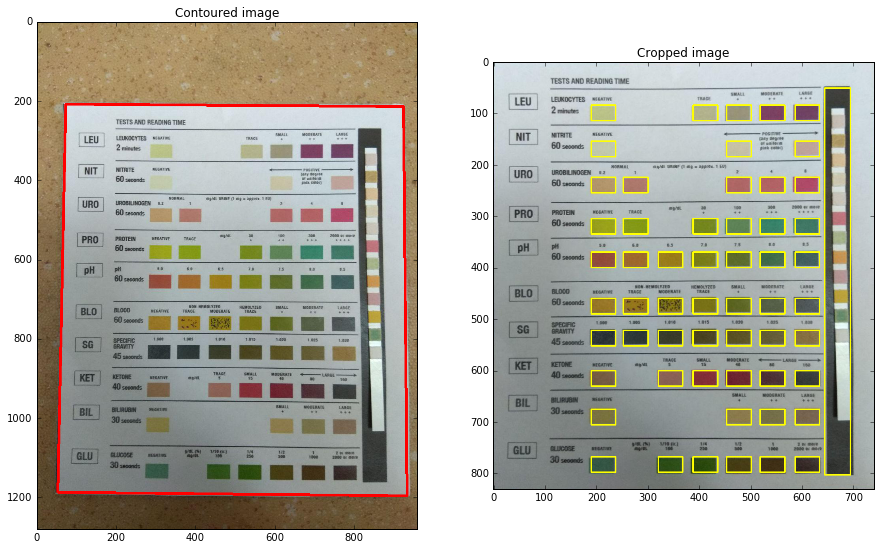

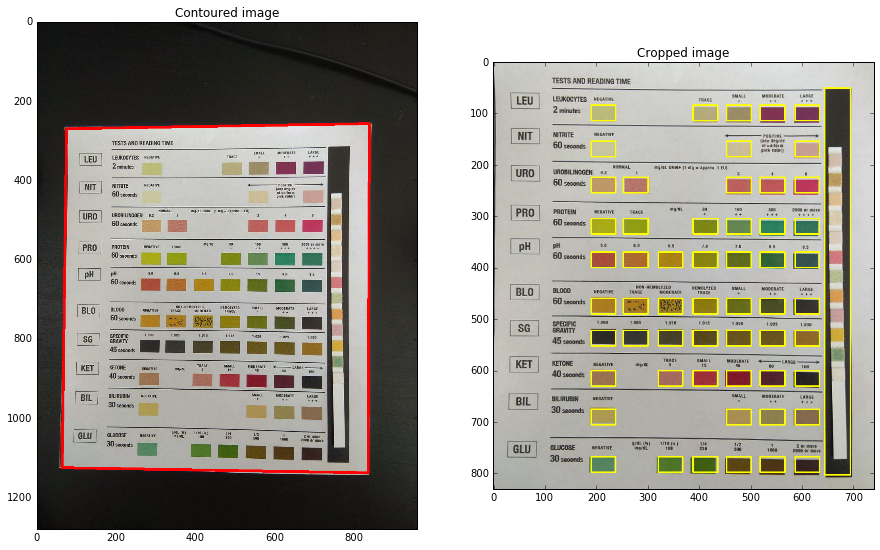

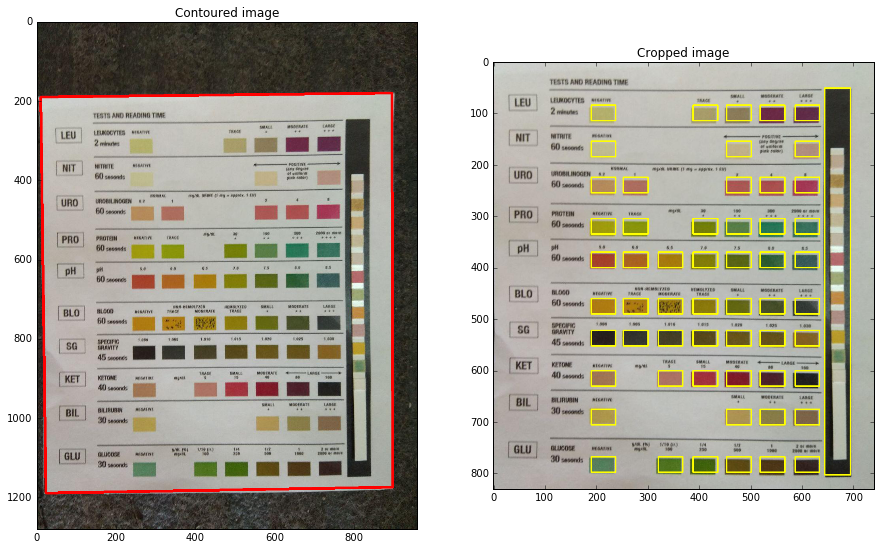

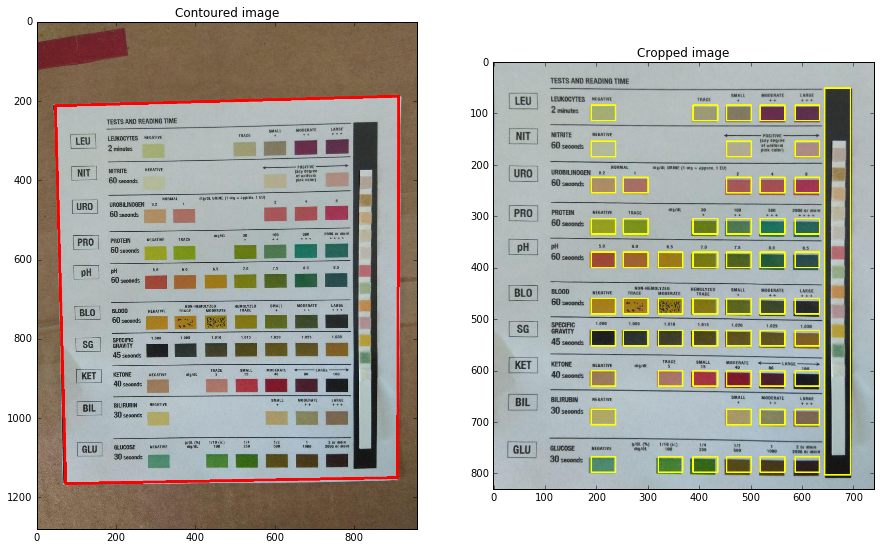

Failed to approx with 4 points


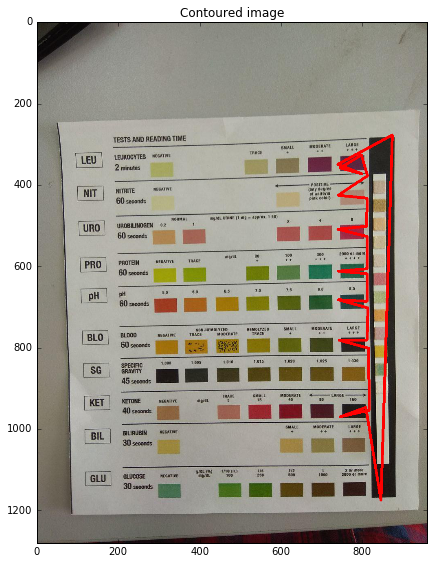

In [11]:
images_warped = []
for image in images:
    images_warped.append(run_on_table(image))

Комментарий:

* Фотографии с шаблоном на белом фоне не прокатят (для автоматической разметки; можно добавить режим ручного оконтуривания шаблона установкой 4 точек на картинку по углам шаблона)
* Печать на тонкой бумаге $\rightarrow$ листок по краям выгибается $\rightarrow$ трансформирование в прямоугольник происходит "с нятяжкой" к углам (может быть, добавить в центр шаблона опорную точку, чтобы она тоже учитывалась при трансформации?)

Часть 2 - детектирование полоски внутри черного поля:

In [145]:
def run_on_strip(image):

    if image is None:
        return None
        
    strip_rect = image[coords_scaled['strip'][0][1]: coords_scaled['strip'][1][1],
                       coords_scaled['strip'][0][0]: coords_scaled['strip'][1][0],
                       :]
    
    strip_rect = cv2.rotate(strip_rect, cv2.ROTATE_90_CLOCKWISE)
    
    # Предобработка
    strip_rect_denoised = denoise(strip_rect, ksize=9)
#     strip_rect_contours = find_contours(strip_rect_denoised)
    strip_rect_binary = binarize(strip_rect_denoised, blocksize=9)
    strip_rect_morph = denoise(strip_rect_binary, ksize=3)
    strip_rect_morph = denoise(strip_rect_morph, ksize=3)
    strip_rect_morph = morphology_close(strip_rect_morph, ksize=3)
#     strip_rect_morph = morphology_close(strip_rect_morph, ksize=5)
    
    
    plt.figure(figsize=(15, 8))
    plt.subplot(4, 1, 1)
    plt.title("Strip rect")
    plt.imshow(strip_rect)    
    plt.subplot(4, 1, 2)
    plt.title("Denoised")
    plt.imshow(strip_rect_denoised)
    plt.subplot(4, 1, 3)
    plt.title("Binary")
    plt.imshow(strip_rect_binary)
    plt.subplot(4, 1, 4)
    plt.title("Morphed")
    plt.imshow(strip_rect_morph)
    plt.show()
    
    
    # Контуры
    r, contours, h = cv2.findContours(strip_rect_morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxId = get_max_area_contour_id(contours)
    contour = contours[maxId]
    
    strip_rect_contoured = strip_rect.copy()
    cv2.drawContours(strip_rect_contoured, [contour], 0, (255, 0, 0), 1)
        
    good_contours = [contour]
    for cont in contours:
        if check_contour(cont, eps_area=100):
            good_contours.append(cont)
#             cv2.drawContours(strip_rect_contoured, [cont], 0, (0, 255, 0), 2)
    the_contour = reduce(lambda x, y: np.concatenate((x, y)), good_contours)
#     cv2.drawContours(strip_rect_contoured, [the_contour], 0, (255, 255, 255), 2)
    
    
    strip_rect_contoured = strip_rect.copy()
#     cv2.drawContours(strip_rect_contoured, [contour], 0, (255, 0, 0), 1)
    
    poly = approximate_contour(the_contour, eps=2*1e-3, closed=False)
    cv2.drawContours(strip_rect_contoured, [poly], 0, (255, 255, 0), 1)
    
    # Трансформация
    rotated_rect = cv2.minAreaRect(poly)
    
    src_points = np.int0(cv2.boxPoints(rotated_rect))
    cv2.drawContours(strip_rect_contoured, [src_points], 0, (255, 255, 255), 1)

    correct_arrangement = get_correct_arrangement(src_points)
    src_rect = np.expand_dims(src_points[correct_arrangement], 1)
    
    dist_rect = np.array([[[0, 0]],
                          [[w_strip, 0]],
                          [[w_strip, h_strip]],
                          [[0, h_strip]]])

    warp_matrix = get_warp_matrix(src_rect, dist_rect)
    strip_warped = warp(strip_rect, warp_matrix, dist_shape=(w_strip, h_strip))
    
    plt.figure(figsize=(15, 4))
    plt.subplot(2, 1, 1)
    plt.title("Contoured image")
    plt.imshow(strip_rect_contoured)
    plt.subplot(2, 1, 2)
    plt.title("Cropped image")
    plt.imshow(strip_warped)
    plt.show()
    
    print "* * * " * 15
    
    return strip_warped

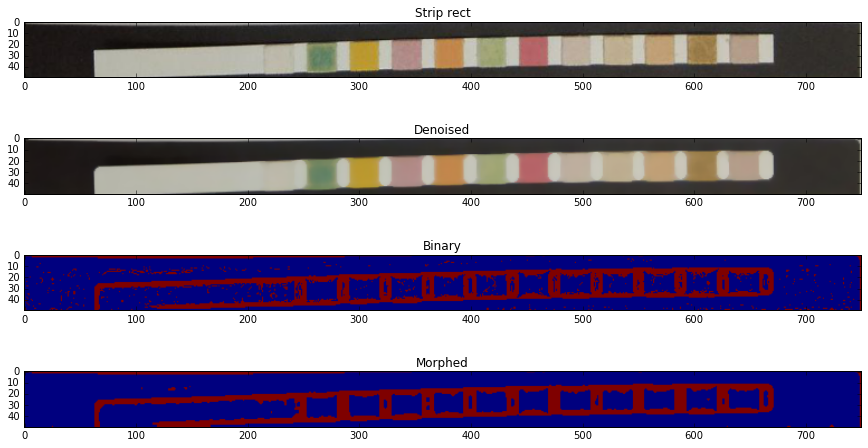

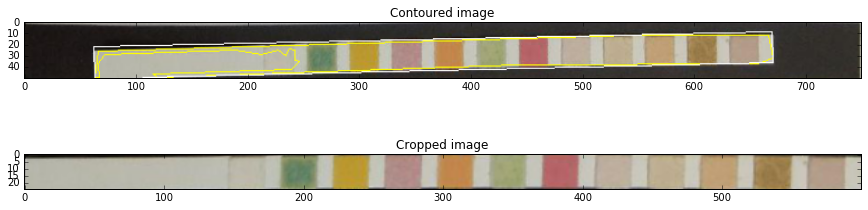

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


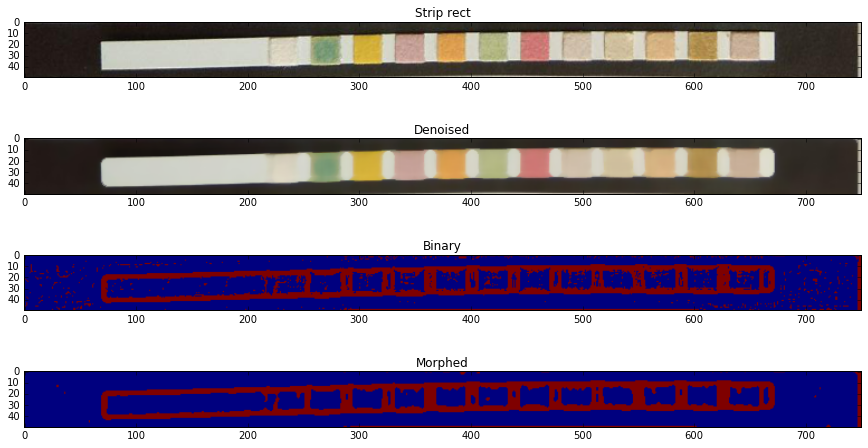

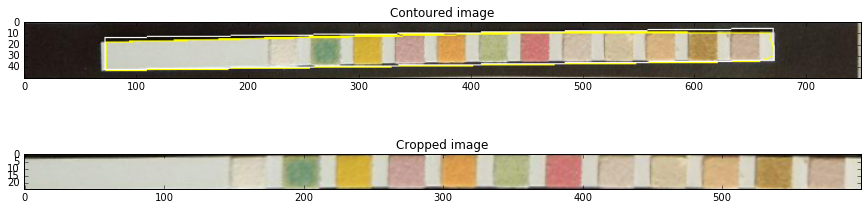

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


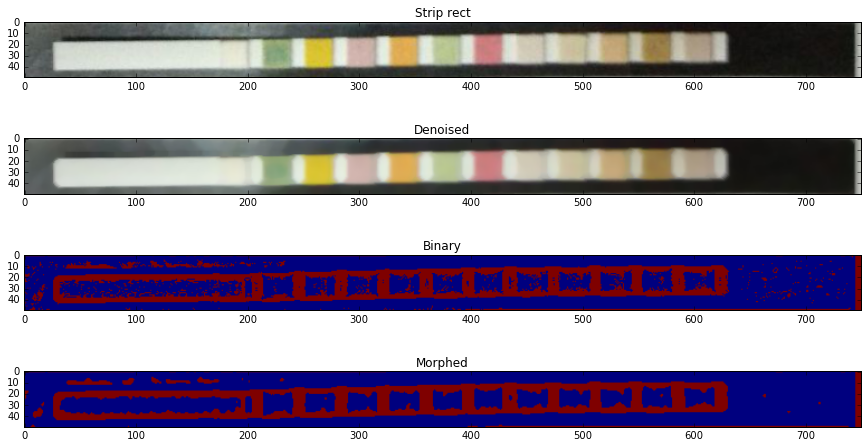

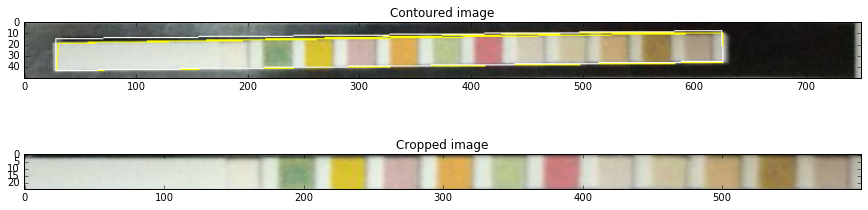

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


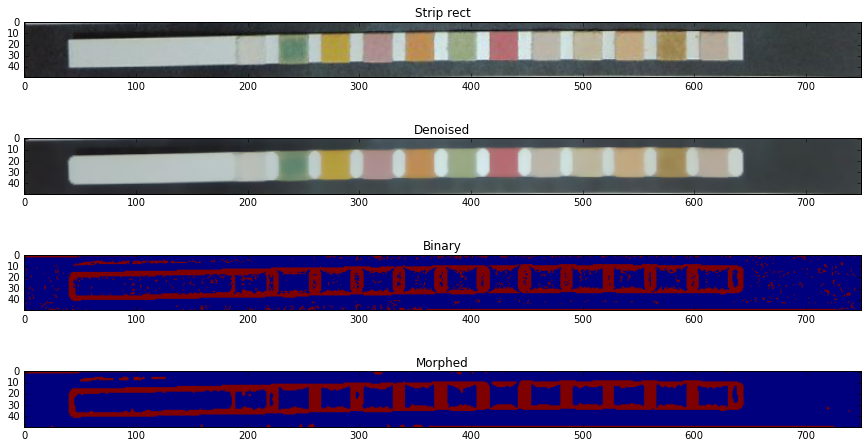

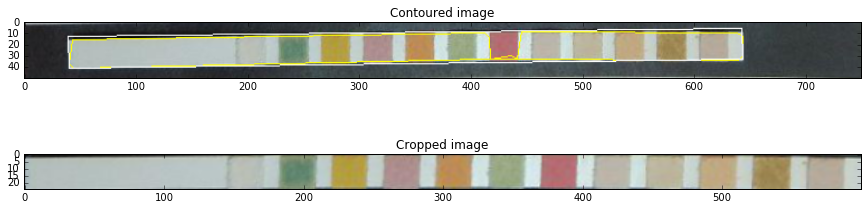

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


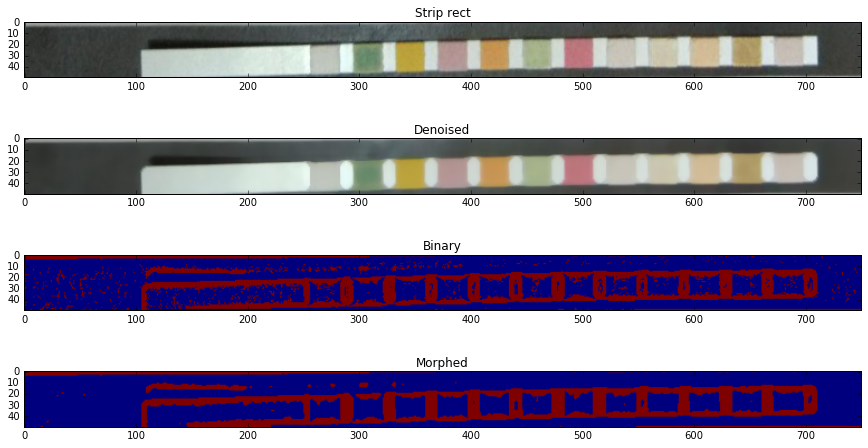

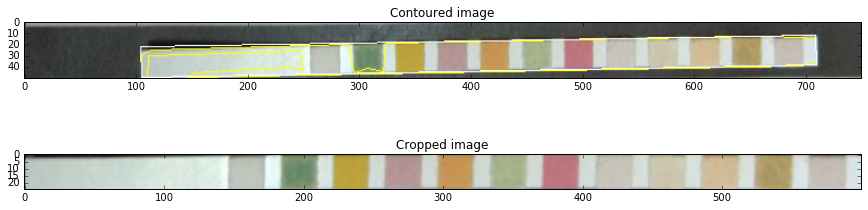

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


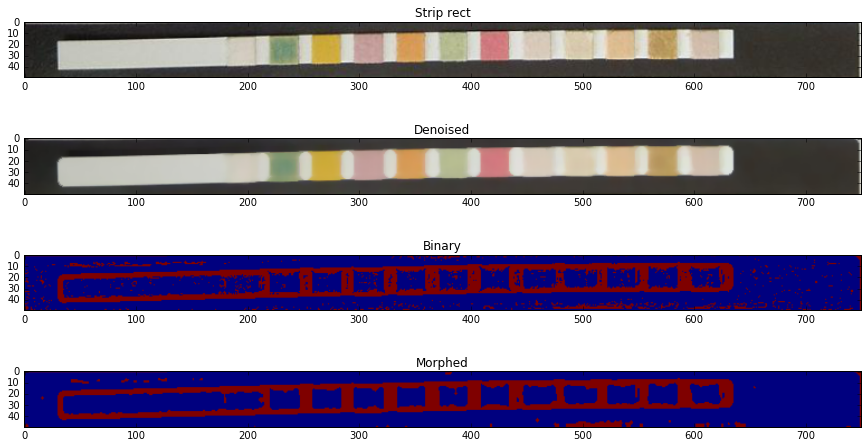

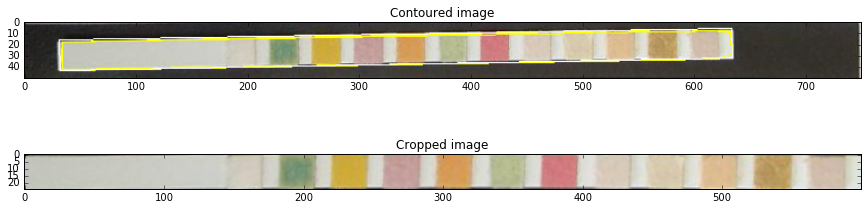

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


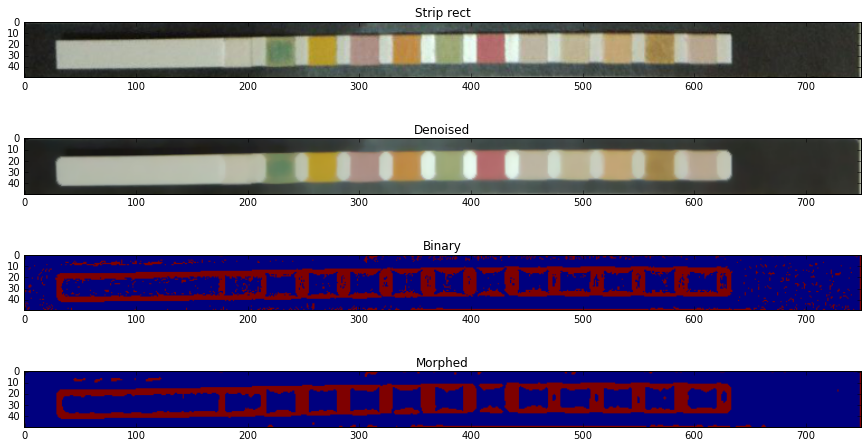

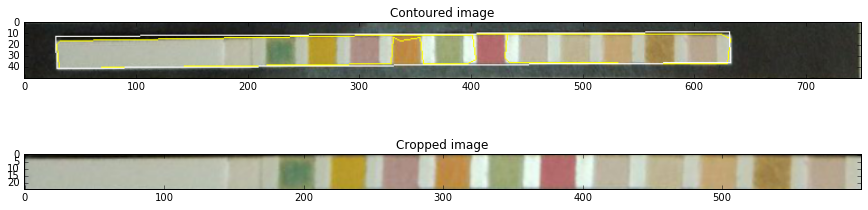

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


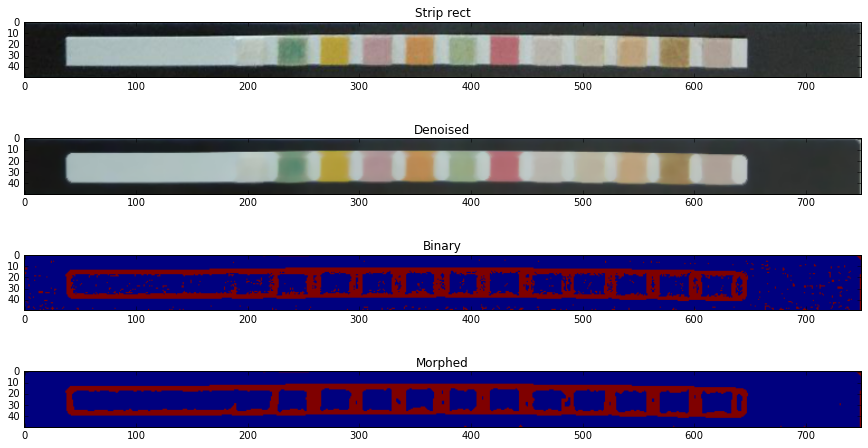

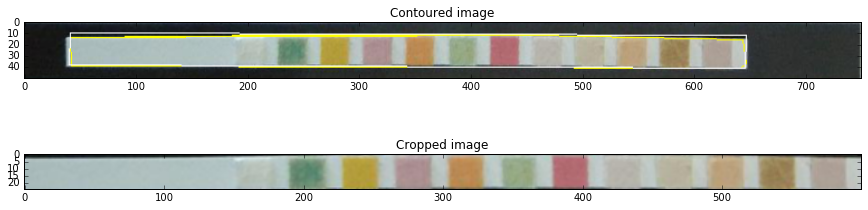

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


In [146]:
strips = []
for image_warped in images_warped:
    strips.append(run_on_strip(image_warped))

Комментарий:

* Для корректного определения границ полоски необходимо класть ее так, чтобы она целиком лежала в своей ячейке (причем желательно с зазором)